In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import tensorflow as tf
import pickle
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.plotting import color_dict, marker_dict, core_legend, scatter_random_z

2024-07-31 10:09:28.905078: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 10:09:28.906509: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 10:09:28.931488: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 10:09:28.932088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 10:09:29.418624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_train = pd.read_csv(data_dir / "training_data.csv")
df_val = pd.read_csv(data_dir / "validation_data.csv")

model_dir = Path("../../models/")

In [4]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.SSE
    is_nn: bool = False
    prediction_train = np.zeros(len(df_train))
    prediction_val = np.zeros(len(df_val))

In [5]:
experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]

In [6]:
for experiment in experiments:
    x_train, _ = data_prep(
        df_train, experiment.features, experiment.target, experiment.is_nn
    )
    x_val, _ = data_prep(
        df_val, experiment.features, experiment.target, experiment.is_nn
    )
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        # First element because uncertainty is not needed
        experiment.prediction_train = model.predict(x_train, verbose=0)[0]
        experiment.prediction_val = model.predict(x_val, verbose=0)[0]
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        experiment.prediction_train = model.predict(x_train)
        experiment.prediction_val = model.predict(x_val)

2024-07-31 10:09:53.253296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,7]
	 [[{{node inputs}}]]
2024-07-31 10:09:53.255254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,7]
	 [[{{node Placeholder}}]]
2024-07-31 10:09:53.283572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,7]
	 [[{{node inputs}}]]
2024-07-31 1

# Validation set

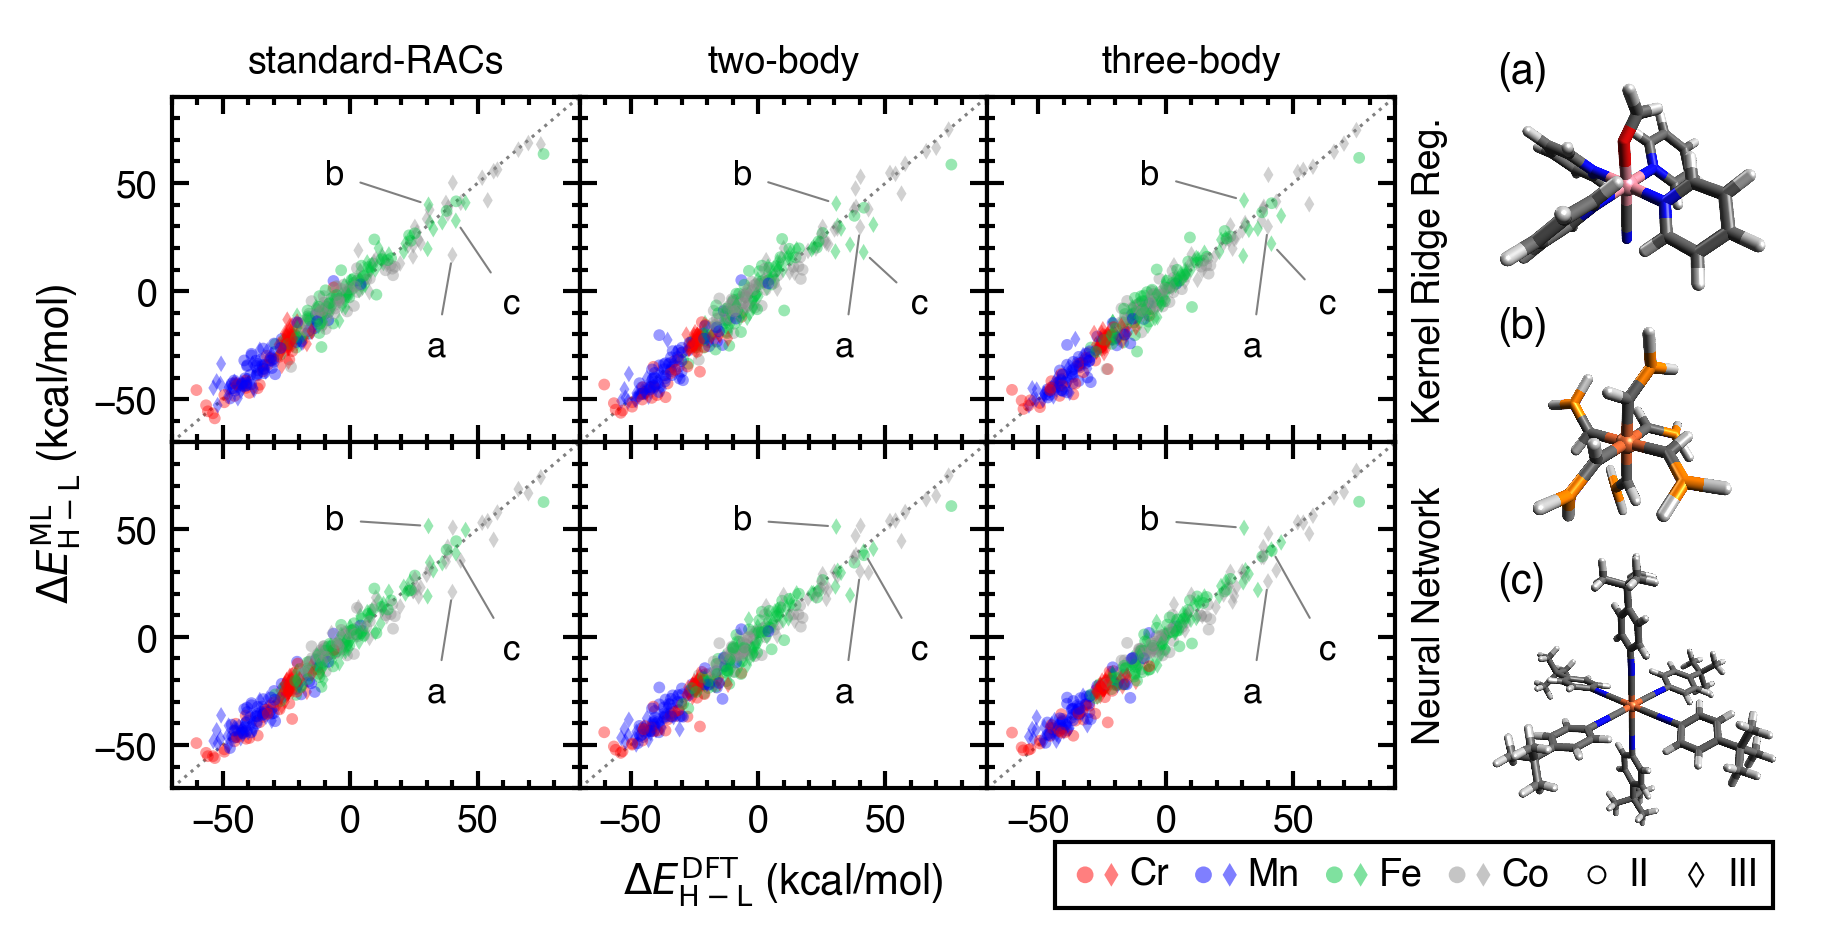

In [7]:
_, y_val = data_prep(df_val, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False)
cores_val = df_val[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values

figsize = (5.91, 0.5 * 5.91)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.09,
    "right": 0.78,
    "top": 0.93,
    "bottom": 0.15,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=3,
    nrows=2,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 8, "alpha": 0.4, "edgecolors": "none"}
lower_lim = -70
upper_lim = 90

for experiment, ax in zip(experiments, axes.flatten()):
    colors = np.array([color_dict[core[:2]] for core in cores_val])
    markers = np.array([marker_dict[core[-1]] for core in cores_val])
    scatter_random_z(
        ax,
        y_val,
        experiment.prediction_val,
        colors,
        markers,
        **scatter_kwargs,
    )
    # Plot parity line:
    ax.plot(
        [lower_lim, upper_lim],
        [lower_lim, upper_lim],
        color="0.5",
        linewidth=0.75,
        zorder=0.5,
        linestyle=":",
    )
    # Set limits and ticks
    ax.set_xlim([lower_lim, upper_lim])
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xticks(10 * np.arange(-7, 10), minor=True)
    ax.set_yticks(10 * np.arange(-7, 10), minor=True)

fig.text(
    gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
    gridspec_kw["bottom"] - 0.12,
    "$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    ha="center",
)
fig.text(
    0.01,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$\Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    rotation=90,
    va="center",
)

for i, label in enumerate(["Kernel Ridge Reg.", "Neural Network"]):
    axes[i, -1].set_ylabel(label, fontsize=9)
    axes[i, -1].yaxis.set_label_position("right")
for i, label in enumerate(["standard-RACs", "two-body", "three-body"]):
    axes[0, i].set_title(label, fontsize=9)

# Legend
core_legend(
    axes[-1, -1],
    legend_kwargs=dict(
        loc="lower left",
        bbox_to_anchor=[0.12, -0.4],
        markerscale=0.9,
        handletextpad=0.08,
        ncols=6,
        columnspacing=0.52,
    ),
)

annotations = [
    (251, "a", (30, -30)),
    (51, "b", (-10, 50)),
    (352, "c", (60, -10)),
]
for experiment, ax in zip(experiments, axes.flatten()):
    for ind, s, xytext in annotations:
        ax.annotate(
            s,
            xy=(y_val[ind], experiment.prediction_val[ind]),
            xytext=xytext,
            fontsize="small",
            arrowprops=dict(arrowstyle="-", linewidth=0.5, color="0.5"),
        )

inset_size = (1,)
insets = [
    ("a", "plots/co_3_pyr_pyr_pyr_pyr_cyanide_formaldehyde_LS.png", 0.062, 0.5),
    (
        "b",
        "plots/fe_3_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_LS.png",
        0.044,
        0.55,
    ),
    ("c", "plots/fe_3_pisc_pisc_pisc_pisc_pisc_pisc_LS.png", 0.063, 0.51),
]
x_offset = 4.9
y_offset = 1.95
for i, (s, path, scale, y) in enumerate(insets):
    ax = fig.add_axes(
        (
            (x_offset) / figsize[0],
            (- 0.85 * i + y_offset) / figsize[1],
            1 / figsize[0],
            1 / figsize[1],
        )
    )
    ax.text(0.05, 0.95, f"({s})", fontsize="medium", ha="left", va="top")
    im = mpimg.imread(path)
    imagebox = OffsetImage(im, zoom=scale)
    ab = AnnotationBbox(imagebox, (0.5, y), frameon=False)
    ax.add_artist(ab)
    ax.set_axis_off()


fig.savefig("plots/parity_plot_sse_val_horizontal.pdf", dpi=400)